In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv("/content/Fraud.csv")
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,1
newbalanceOrig,1
nameDest,1
oldbalanceDest,1
newbalanceDest,1
isFraud,1


In [3]:
df.dropna(inplace=True)

In [4]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [5]:
num_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df = remove_outliers(df, num_cols)

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
df['type'] = LabelEncoder().fit_transform(df['type'])
X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          Feature       VIF
0            step  6.665574
1            type  4.544188
2          amount  3.293098
3   oldbalanceOrg  1.927978
4  newbalanceOrig  1.755560
5  oldbalanceDest  5.090280
6  newbalanceDest  7.888393


In [7]:
df.drop(columns=['step'], inplace=True)

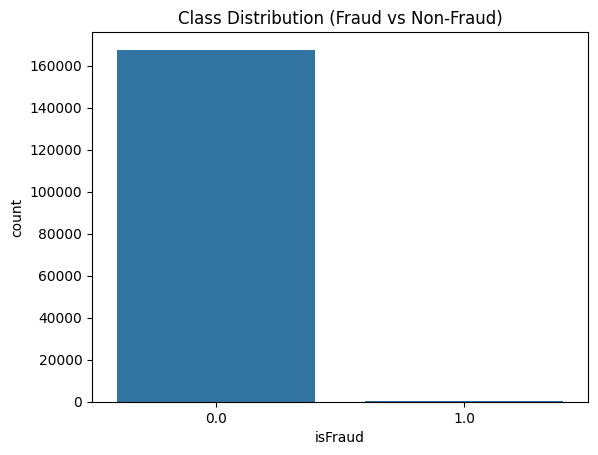

isFraud
0.0    0.999231
1.0    0.000769
Name: proportion, dtype: float64


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='isFraud', data=df)
plt.title("Class Distribution (Fraud vs Non-Fraud)")
plt.show()
print(df['isFraud'].value_counts(normalize=True))

isFraud
0.0    91835.203816
1.0    83651.138217
Name: amount, dtype: float64


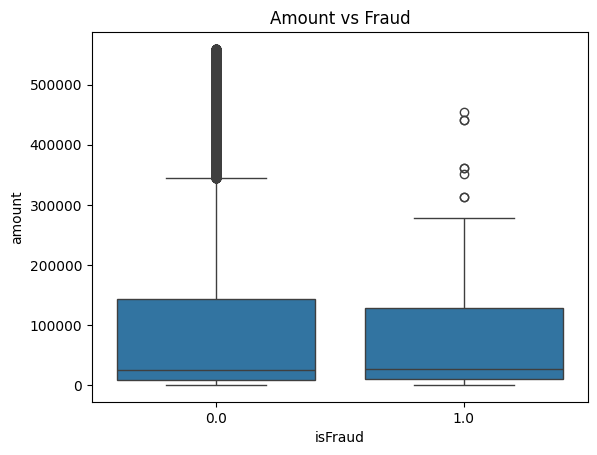

In [9]:
print(df.groupby('isFraud')['amount'].mean())
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title("Amount vs Fraud")
plt.show()

type
1    66
4    63
Name: count, dtype: int64


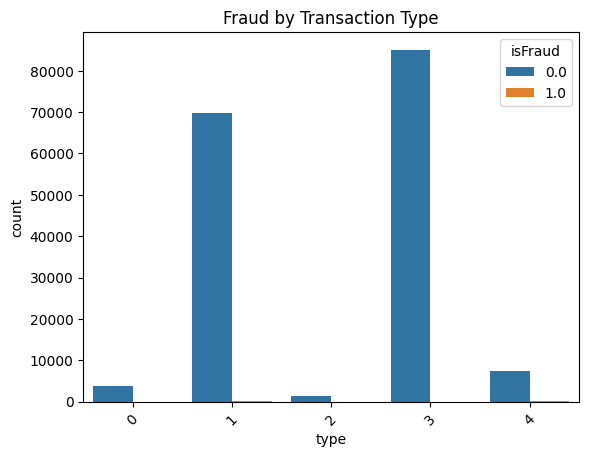

In [10]:
fraud_by_type = df[df['isFraud'] == 1]['type'].value_counts()
print(fraud_by_type)
sns.countplot(x='type', hue='isFraud', data=df)
plt.title("Fraud by Transaction Type")
plt.xticks(rotation=45)
plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [13]:
from sklearn.model_selection import train_test_split
X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
!pip install imbalanced-learn

In [16]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_res, y_res)

y_pred = model.predict(X_test)

In [18]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Confusion Matrix:
 [[33404   126]
 [   10    16]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     33530
         1.0       0.11      0.62      0.19        26

    accuracy                           1.00     33556
   macro avg       0.56      0.81      0.59     33556
weighted avg       1.00      1.00      1.00     33556

ROC-AUC Score: 0.8058133932872973


In [19]:
import pandas as pd
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

          Feature  Importance
2   oldbalanceOrg    0.297714
0            type    0.188167
5  newbalanceDest    0.143840
4  oldbalanceDest    0.126506
3  newbalanceOrig    0.126297
1          amount    0.117476


Q6: Do these factors make sense? How?

Yes, these factors definitely make sense because they align well with what we know about fraudulent behavior. For example, fraud usually happens with large transaction amounts that’s a common red flag. Also, fraudsters tend to use transaction types like TRANSFER or CASH_OUT since these help move money quickly. Often, when fraud occurs, the original account balance drops to zero, which indicates the account has been drained. Plus, suspicious transactions often show discrepancies between the new balance and the transaction amount, which is another clear sign something’s off.


Q7: What kind of prevention should be adopted?

To prevent fraud effectively, we need a proactive approach. This includes having a real time monitoring system powered by a trained machine learning model that can spot risky transactions immediately. Alerts should be triggered when transactions show risky patterns like large amounts combined with transfer types and low source balances. Adding 2 Factor Authentication (2FA) before allowing any high value transaction adds a layer of security. An anomaly scoring system can help flag transactions that don’t match usual user behavior. Behavioral profiling tracks typical user transaction patterns to detect anything unusual. Lastly, monitoring the geographic location of logins or transactions (Geo-IP) can raise flags if something happens far from the user’s normal area.

Q8: How would you determine if these actions worked?

We can tell if the prevention measures are working by looking at a few key indicators. First, a clear drop in actual fraud cases over time shows the system is effective. We also want to see an increase in True Positives, meaning more fraud cases are caught correctly, and a decrease in False Negatives, meaning fewer frauds slip through. Customer feedback and trust levels improving is another great sign. On the technical side, improved Precision and Recall metrics in the real time detection model show it’s getting better at identifying fraud. Finally, if operational costs drop because there’s less manual investigation needed, that means the system is doing its job well.